# Group project

By delivering this notebook, we confirm that the group project was developed by the following students.

## Student 1: STUDENT NAME, STUDENT NUMBER (TO BE FILLED BY THE STUDENT)
## Student 2: STUDENT NAME, STUDENT NUMBER (TO BE FILLED BY THE STUDENT)


The group project will focus on analysing data on flights in the US.

Unless otherwise specified, the problems can be solved using either Spark or Pandas.

Some useful links:

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)


## Colab setup

The following cell will install Spark, if the notebook is running on COLAB. Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing)

In [1]:
#Run this cell to install Spark on Colab
import os

if 'COLAB_GPU' in os.environ : 
    !apt-get install openjdk-8-jdk-headless
    !pip install pyspark==3.1.2
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.1-s_2.12.jar pyspark-shell'

    from google.colab import drive
    drive.mount('/content/drive')



## Local setup

For running the group project locally, you should create a directory named **data** in the directory where you have this notebook. Then, you should download to the **data** directory the files in the following link: [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing).

## Initialization

Import libraries. 

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
import seaborn as sns

plt.style.use('seaborn')

print(pyspark.__version__)


3.1.2


Let's start spark session and set *log* level to ERROR.

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if 'COLAB_GPU' in os.environ : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.1-s_2.12.jar')
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar')


spark.sparkContext.setLogLevel("ERROR")

21/12/07 19:16:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Data selection

This cell controls the dataset you will be using. Note that this cell will control the path to the files, dependening on the platform you are using to run the code.


In [3]:
# Comment the following 
flightsF = "sample.csv"
# flightsF = "complete.csv"
#flightsF = "data-2009.csv"
#flightsF = "data-2010.csv"
#flightsF = "data-2011.csv"
#flightsF = "data-2012.csv"
#flightsF = "data-2013.csv"
#flightsF = "data-2014.csv"
#flightsF = "data-2015.csv"
#flightsF = "data-2016.csv"
#flightsF = "data-2017.csv"
#flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/group2122/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/group2122/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/group2122/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")

## Datasets

This section describes the datasets you have available for your analysis.

### Flights

The flights dataset, generated from data available at [https://www.transtats.bts.gov/DataIndex.asp](https://www.transtats.bts.gov/DataIndex.asp), includes the following columns:

* FL_DATE: date of the flight (format: yyyy-mm-dd)
* OP_CARRIER: carrier code
* OP_CARRIER_FL_NUM: carrier flight number
* ORIGIN: origin airport (using IATA codes)
* DEST: destination airport (using IATA codes)
* CRS_DEP_TIME: scheduled local departure time (format for all times: hh:mm)
* DEP_TIME: actual departure time
* DEP_DELAY: departure delay, in minutes
* TAXI_OUT: taxi out time
* WHEELS_OFF: actual local wheel off time
* WHEELS_ON: actual local wheel on time
* TAXI_IN: actual local taxi in time
* CRS_ARR_TIME: scheduled local arrival time
* ARR_TIME: actual arrival time
* ARR_DELAY: arrival delay, in minutes
* CANCELLED: 1 if the flight has been cancelled; 0 otherwise
* CANCELLATION_CODE: code of cancelation (A = carrier, B = weather, C = NAS, D = security)
* DIVERTED: 1 if the flight has been diverted; 0 otherwise
* CRS_ELAPSED_TIME: estimated elapsed time
* ACTUAL_ELAPSED_TIME: actual elapsed time
* AIR_TIME: flight time, in minutes
* DISTANCE: flight distance, in miles
* CARRIER_DELAY: delay due to carrier, in minutes
* WEATHER_DELAY: delay due to weather, in minutes
* NAS_DELAY: delay due to NAS, in minutes
* SECURITY_DELAY: delay due to security, in minutes
* LATE_AIRCRAFT_DELAY: delay due to late aircraft, in minutes

The following data files are available:

* complete.csv : complete data set, including data from 2009 to 2018
* sample.csv : sample data set, including data from July 1 to July 15, from years 2009 to 2018
* data-20xx.csv : data set for a particular year

Load the dataset into flightsDF dataframe and register flights under view name **flights**. We are setting the schema programmatically, because inferring the schema in a very large dataframe is slow.


In [4]:
flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights")

flightsDF.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-07-01|        XE|             5

### Airports

The airports dataset includes the information about US airports - soure: [https://datahub.io/core/airport-codes](https://datahub.io/core/airport-codes).

This dataset includes the following columns:

* ident: identifier
* type: type of airport
* name: name of airport
* elevation_ft: altitude, in feets
* continent: code of continent
* iso_country: coide of country
* iso_regio: code of region
* municipality: city
* gps_code: code of GPS
* iata_code: IATA code of aurport
* local_code: local code of airport
* coordinates: coordinates of airport

Load the dataset into airportDF dataframe and register airports under view name **airports**.


In [5]:
airportsDF = spark.read.option("header", True).option("inferSchema",True).csv(AIRPORTS_FILENAME)

airportsDF.createOrReplaceTempView("airports")

airportsDF.show(3)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
+-----+-------------+--------------------+------------+---------+-----------+-----

Exemplify how you can plot information about airports.

Plotting airport location - using altitude for different color


<AxesSubplot:xlabel='lon', ylabel='lat'>

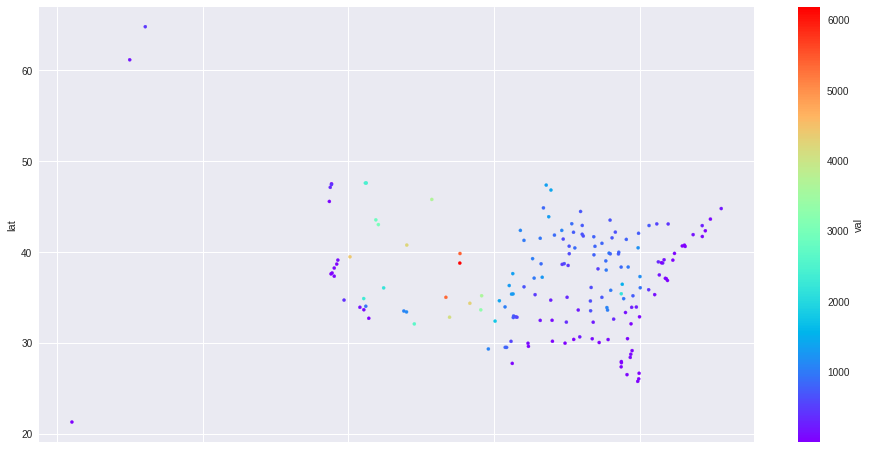

In [6]:
airportLocDF = spark.sql("""SELECT FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))) AS lon,
                                    FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))) AS lat,
                                    elevation_ft AS val
                        FROM airports 
                        WHERE type = 'large_airport' AND continent = 'NA' AND iso_country = 'US'""")

print('Plotting airport location - using altitude for different color')
airportLocPD = airportLocDF.toPandas()
airportLocPD.plot(x="lon",y="lat",c="val",s=10,cmap="rainbow",kind="scatter", figsize=(16,8))

### Public holidays

Dates of public holidays in the US.

This dataset includes the following columns:

* Date: date (format: yyyy-mm-dd)
* Holiday: name of the holiday
* WeekDay: day of week
* Month: month (1-12)
* Day: day (1-31)
* Year: year (2002-2021)

Load the dataset into holidaysDF dataframe and register holidays under view name **holidays**.


In [7]:
holidaysDF = spark.read.option("header", True).option("inferSchema",True).csv(HOLIDAYS_FILENAME)

holidaysDF.createOrReplaceTempView("holidays")

holidaysDF.show(3)

+----------+-----------+-------+-----+---+----+
|      Date|    Holiday|WeekDay|Month|Day|Year|
+----------+-----------+-------+-----+---+----+
|2004-07-04|4th of July| Sunday|    7|  4|2004|
|2005-07-04|4th of July| Monday|    7|  4|2005|
|2006-07-04|4th of July|Tuesday|    7|  4|2006|
+----------+-----------+-------+-----+---+----+
only showing top 3 rows



## Problem 0 [1 point]

We start by executing some simple statistics to compare the execution time between Spark and Pandas.


### Code: Spark

In [16]:
start_time = time.time()

flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result = spark.sql("SELECT OP_CARRIER, count(*) AS num_flights FROM flights_new GROUP BY OP_CARRIER")
result.show()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))

+----------+-----------+
|OP_CARRIER|num_flights|
+----------+-----------+
|        UA|    4826658|
|        NK|     588574|
|        AA|    6682161|
|        NW|     292400|
|        EV|    4726445|
|        B6|    2483969|
|        DL|    7841880|
|        OO|    6263052|
|        F9|     903218|
|        YV|    1063558|
|        US|    2657286|
|        MQ|    3216260|
|        OH|     577060|
|        HA|     744991|
|        XE|    1105864|
|        G4|      96221|
|        YX|     316090|
|        AS|    1660539|
|        FL|    1218389|
|        CO|     740498|
+----------+-----------+
only showing top 20 rows

Runtime = 286.83185291290283


* Execution time for sample.csv: 
* Execution time for complete.csv: 

Using GPU @ Colab (go to Execution time menu and change the type of execution time to include GPU):

* Execution time for sample.csv: 
* Execution time for complete.csv: 


### Code: Pandas library

In [ ]:
import pandas as pd
import time

start_time = time.time()
mySchema = {"FL_DATE": "str",
            "OP_CARRIER": "str",
            "OP_CARRIER_FL_NUM":"Int64",
            "ORIGIN":"str",
            "DEST":"str",
            "CRS_DEP_TIME":"str",
            "DEP_TIME":"str",
            "DEP_DELAY":"Int64",
            "TAXI_OUT":"Int64",
            "WHEELS_OFF":"str",
            "WHEELS_ON":"str",
            "TAXI_IN":"Int64",
            "CRS_ARR_TIME":"str",
            "ARR_TIME":"str",
            "ARR_DELAY":"Int64",
            "CANCELLED":"Int64",
            "CANCELLATION_CODE":"str",
            "DIVERTED":"Int64",
            "CRS_ELAPSED_TIME":"Int64",
            "ACTUAL_ELAPSED_TIME":"Int64",
            "AIR_TIME":"Int64",
            "DISTANCE":"Int64",
            "CARRIER_DELAY":"Int64",
            "WEATHER_DELAY":"Int64",
            "NAS_DELAY":"Int64",
            "SECURITY_DELAY":"Int64",
            "LATE_AIRCRAFT_DELAY":"Int64"
           }

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)
result = dataframe[["FL_DATE","OP_CARRIER"]].groupby("OP_CARRIER").count()
print(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

* Execution time for sample.csv: 
* Execution time for complete.csv: 

**Discuss the results you have obtained:**

For Sample.csv, we have on Spark 15.034723281860352 seconds, and on Pandas 40.35684871673584 seconds.

For Complete.csv, we have on Spark 286.83185291290283, and on Pandas our computers always aborts the calculus.

_**The difference can be explained by how the computation are made. Pyspark uses Map-Reduce concept, which very fast for large datasets. Dividing the task to smaller ones and executing them in parallel reduce data latency which makes it faster than normal one from Pandas, which does all computations on the data at one time.**_

## Problem 1 [4 points]

In this first problem, you should compute a set of statistics on the data.


### Top-20 airports with more flights (include the name of the airport)

In [9]:
# TO COMPLETE
originDF = spark.sql("""SELECT F.ORIGIN, COUNT(ORIGIN) AS count_origin
                       FROM flights F INNER JOIN airports A ON F.ORIGIN=A.iata_code 
                       GROUP BY(ORIGIN)
                       ORDER BY(count_origin) DESC""")
originDF.createOrReplaceTempView("origin")

destDF = spark.sql("""SELECT F.DEST, COUNT(DEST) AS count_dest
                       FROM flights F INNER JOIN airports A ON F.DEST=A.iata_code 
                       GROUP BY(DEST)
                       ORDER BY(count_dest) DESC""")
destDF.createOrReplaceTempView("dest")

In [10]:
totalDF = spark.sql("""SELECT O.ORIGIN AS airport, O.count_origin + D.count_dest AS total
                     FROM origin O INNER JOIN dest D ON O.ORIGIN=D.DEST 
                     ORDER BY (total) DESC""")
totalDF.createOrReplaceTempView("total_df")

spark.sql("""SELECT A.name, T.* FROM airports A INNER JOIN total_df T ON A.iata_code=T.airport ORDER BY(total) DESC""").show(20)

+--------------------+-------+------+
|                name|airport| total|
+--------------------+-------+------+
|Hartsfield Jackso...|    ATL|295144|
|Chicago O'Hare In...|    ORD|230090|
|Dallas Fort Worth...|    DFW|191254|
|Denver Internatio...|    DEN|179855|
|Los Angeles Inter...|    LAX|167369|
|Phoenix Sky Harbo...|    PHX|127661|
|George Bush Inter...|    IAH|127206|
|San Francisco Int...|    SFO|126095|
|McCarran Internat...|    LAS|110673|
|Minneapolis-St Pa...|    MSP|102971|
|Detroit Metropoli...|    DTW|100084|
|Charlotte Douglas...|    CLT| 99251|
|Seattle Tacoma In...|    SEA| 98724|
|Orlando Internati...|    MCO| 93995|
|General Edward La...|    BOS| 90605|
|Salt Lake City In...|    SLC| 88530|
|Newark Liberty In...|    EWR| 88330|
|John F Kennedy In...|    JFK| 83848|
|  La Guardia Airport|    LGA| 79760|
|Baltimore/Washing...|    BWI| 78621|
+--------------------+-------+------+
only showing top 20 rows



### Top-20 days with more flights

In [215]:
spark.sql("""SELECT FL_DATE AS date, COUNT(FL_DATE) AS total FROM flights
            GROUP BY (date)
            ORDER BY (total) DESC""").show(20)

+----------+-----+
|      date|total|
+----------+-----+
|2018-07-13|22022|
|2018-07-12|21966|
|2018-07-09|21956|
|2018-07-11|21736|
|2018-07-10|21628|
|2018-07-15|21262|
|2018-07-08|21251|
|2018-07-06|20393|
|2018-07-01|19985|
|2018-07-02|19727|
|2018-07-05|19649|
|2009-07-10|19425|
|2009-07-02|19399|
|2013-07-12|19391|
|2009-07-09|19377|
|2009-07-06|19362|
|2013-07-08|19361|
|2009-07-13|19356|
|2013-07-15|19354|
|2013-07-11|19349|
+----------+-----+
only showing top 20 rows



### Periods with more flights: (morning 00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)

In [30]:
morningDF = spark.sql("""SELECT FL_DATE, ORIGIN, DEST, DEP_TIME, ARR_TIME
                         FROM flights WHERE (DEP_TIME < "11:59" AND DEP_TIME > "00:00") OR (ARR_TIME < "11:59" AND ARR_TIME > "00:00") """)

middayDF = spark.sql("""SELECT FL_DATE, ORIGIN, DEST, DEP_TIME, ARR_TIME
                         FROM flights WHERE (DEP_TIME < "17:59" AND DEP_TIME > "12:00") OR (ARR_TIME < "17:59" AND ARR_TIME > "12:00") """)

eveningDF = spark.sql("""SELECT FL_DATE, ORIGIN, DEST, DEP_TIME, ARR_TIME
                         FROM flights WHERE (DEP_TIME < "23:59" AND DEP_TIME > "18:00") OR (ARR_TIME < "23:59" AND ARR_TIME > "18:00") """)

morningDF.createOrReplaceTempView("morning_df")
middayDF.createOrReplaceTempView("midday_df")
eveningDF.createOrReplaceTempView("evening_df")
#Cancelled

spark.sql("""SELECT COUNT(FL_DATE) AS Flights_morning FROM morning_df""").show()
spark.sql("""SELECT COUNT(FL_DATE) AS Flights_midday FROM midday_df""").show()
spark.sql("""SELECT COUNT(FL_DATE) AS Flights_evening FROM evening_df""").show()

+---------------+
|Flights_morning|
+---------------+
|        1063183|
+---------------+



+--------------+
|Flights_midday|
+--------------+
|       1124181|
+--------------+



+---------------+
|Flights_evening|
+---------------+
|         842172|
+---------------+



### Top-20 airports with longer delays

In [42]:
spark.sql("""SELECT A.name, A.iata_code, F.DEP_DELAY 
             FROM airports A INNER JOIN flights F ON A.iata_code=F.ORIGIN 
             ORDER BY (DEP_DELAY) DESC""").show(20)

+--------------------+---------+---------+
|                name|iata_code|DEP_DELAY|
+--------------------+---------+---------+
|Charlotte Douglas...|      CLT|     2710|
|Portland Internat...|      PDX|     2445|
|McCarran Internat...|      LAS|     1847|
|Indianapolis Inte...|      IND|     1625|
|Charlottesville A...|      CHO|     1543|
|Ellison Onizuka K...|      KOA|     1485|
|Chicago Midway In...|      MDW|     1467|
|Charleston Air Fo...|      CHS|     1422|
|Cleveland Hopkins...|      CLE|     1390|
|McCarran Internat...|      LAS|     1386|
|Fort Lauderdale H...|      FLL|     1377|
|Tucson Internatio...|      TUS|     1332|
|Key West Internat...|      EYW|     1330|
|Will Rogers World...|      OKC|     1324|
|Hartsfield Jackso...|      ATL|     1318|
|Idaho Falls Regio...|      IDA|     1316|
|Sacramento Intern...|      SMF|     1307|
|Albuquerque Inter...|      ABQ|     1302|
|John F Kennedy In...|      JFK|     1295|
|Pittsburgh Intern...|      PIT|     1294|
+----------

### Top 10 carriers with longer delays

In [44]:
spark.sql("""SELECT OP_CARRIER, CARRIER_DELAY 
             FROM flights 
             ORDER BY (CARRIER_DELAY) DESC""").show(10)

+----------+-------------+
|OP_CARRIER|CARRIER_DELAY|
+----------+-------------+
|        NW|         2439|
|        HA|         1845|
|        AA|         1625|
|        MQ|         1527|
|        NW|         1467|
|        AA|         1421|
|        AA|         1386|
|        NW|         1343|
|        EV|         1333|
|        AA|         1332|
+----------+-------------+
only showing top 10 rows



### Longer delays by period: (morning 00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)


In [51]:
spark.sql("""SELECT AVG(CASE WHEN DEP_DELAY < 0 THEN 0 ELSE DEP_DELAY END) AS morningdelay from flights WHERE (DEP_TIME<"11:59" AND DEP_TIME>"00:00") """).show()
spark.sql("""SELECT AVG(CASE WHEN DEP_DELAY < 0 THEN 0 ELSE DEP_DELAY END) AS middaydelay from flights WHERE (DEP_TIME<"17:59" AND DEP_TIME>"12:00") """).show()
spark.sql("""SELECT AVG(CASE WHEN DEP_DELAY < 0 THEN 0 ELSE DEP_DELAY END) AS eveningdelay from flights WHERE (DEP_TIME<"23:59" AND DEP_TIME>"18:00") """).show()

+-----------------+
|     morningdelay|
+-----------------+
|7.168764014946517|
+-----------------+



+------------------+
|       middaydelay|
+------------------+
|13.723491107363303|
+------------------+



+------------------+
|      eveningdelay|
+------------------+
|28.020254425583595|
+------------------+



## Problem 2 [4 points]

Assume you want to create a web site to help travellers get information about flight delays. The web site would allow a user to find out information about delays for the flight she want to take. 
The information about delays should include at least 3 statistics - suggestion: the average delay in the same route of the same carrier in the last 7 days, 30 days, 365 days, similar but considering only flights in the same week day, similar but considering flights in the same week day but excluding holidays, etc.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user.

Write the code to build these indices - for each index, print 5 lines.

In [59]:
maxdate = spark.sql("""SELECT MAX(FL_DATE) FROM flights""")
maxdate = maxdate.toPandas()
maxdate = maxdate.iloc[0]["max(FL_DATE)"]

In [87]:
import datetime
from pyspark.sql.functions import dayofweek
data = spark.sql("""SELECT FL_DATE, OP_CARRIER, ORIGIN, DEST, DEP_DELAY FROM flights""")
data.createOrReplaceTempView("data")
data.where(data["FL_DATE"]>=maxdate-datetime.timedelta(days=7)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)
data.where(data["FL_DATE"]>=maxdate-datetime.timedelta(days=30)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)
data.where(data["FL_DATE"]>=maxdate-datetime.timedelta(days=365)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)

+----------+------+----+-------------------+
|OP_CARRIER|ORIGIN|DEST|     avg(DEP_DELAY)|
+----------+------+----+-------------------+
|        WN|   AUS| ECP| 21.333333333333332|
|        WN|   HRL| AUS|             22.875|
|        WN|   MCI| ATL|  5.607142857142857|
|        WN|   MHT| MCO|                1.4|
|        WN|   MKE| BOS|-3.6923076923076925|
+----------+------+----+-------------------+
only showing top 5 rows



+----------+------+----+-------------------+
|OP_CARRIER|ORIGIN|DEST|     avg(DEP_DELAY)|
+----------+------+----+-------------------+
|        9E|   ATL| GNV|0.02631578947368421|
|        9E|   LGA| MSY| 2.5172413793103448|
|        B6|   SYR| JFK|                8.9|
|        B6|   HPN| MCO|                0.1|
|        B6|   RSW| DCA|  40.06666666666667|
+----------+------+----+-------------------+
only showing top 5 rows



+----------+------+----+------------------+
|OP_CARRIER|ORIGIN|DEST|    avg(DEP_DELAY)|
+----------+------+----+------------------+
|        AS|   PDX| PHL|             -4.75|
|        OO|   FWA| ORD|-1.964705882352941|
|        OO|   MSP| IMT|              1.75|
|        OO|   CID| MSP| 6.833333333333333|
|        OO|   ORD| BGR|              7.75|
+----------+------+----+------------------+
only showing top 5 rows



DataFrame[FL_DATE: date, OP_CARRIER: string, ORIGIN: string, DEST: string, DEP_DELAY: int, Weekday: int]

In [98]:
print("For Wednesday for example")
data = data.withColumn("Weekday", (dayofweek("FL_DATE")))
data.where(data["Weekday"] == 3).where(data["FL_DATE"]>=maxdate-datetime.timedelta(days=7)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)
data.where(data["Weekday"] == 3).where(data["FL_DATE"]>=maxdate-datetime.timedelta(days=30)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)
data.where(data["Weekday"] == 3).where(data["FL_DATE"]>=maxdate-datetime.timedelta(days=365)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)

+----------+------+----+------------------+
|OP_CARRIER|ORIGIN|DEST|    avg(DEP_DELAY)|
+----------+------+----+------------------+
|        9E|   IND| LGA|              -1.0|
|        9E|   CVG| PHL|-6.333333333333333|
|        9E|   LGA| MSY|              -6.0|
|        9E|   ATL| GNV|              -3.0|
|        B6|   SYR| JFK|             -11.0|
+----------+------+----+------------------+
only showing top 5 rows



+----------+------+----+--------------+
|OP_CARRIER|ORIGIN|DEST|avg(DEP_DELAY)|
+----------+------+----+--------------+
|        9E|   ATL| GNV|         -3.25|
|        9E|   LGA| MSY|         -5.25|
|        B6|   SYR| JFK|        -10.75|
|        B6|   HPN| MCO|        -2.625|
|        B6|   RSW| DCA|          62.5|
+----------+------+----+--------------+
only showing top 5 rows



+----------+------+----+--------------+
|OP_CARRIER|ORIGIN|DEST|avg(DEP_DELAY)|
+----------+------+----+--------------+
|        9E|   ATL| GNV|         -3.25|
|        9E|   LGA| MSY|         -5.25|
|        B6|   SYR| JFK|        -10.75|
|        B6|   HPN| MCO|        -2.625|
|        B6|   RSW| DCA|          62.5|
+----------+------+----+--------------+
only showing top 5 rows



In [102]:
print("For Wednesday for example excluding the holidays")

datawhol = spark.sql("""SELECT F.FL_DATE, F.OP_CARRIER, F.ORIGIN, F.DEST, F.DEP_DELAY, H.Date
                        FROM flights F LEFT JOIN holidays H ON F.FL_DATE=H.Date
                        WHERE H.Date IS NULL
                                      """)
datawhol = datawhol.withColumn("Weekday", (dayofweek("FL_DATE")))
datawhol.where(datawhol["Weekday"] == 3).where(datawhol["FL_DATE"]>=maxdate-datetime.timedelta(days=7)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)
datawhol.where(datawhol["Weekday"] == 3).where(datawhol["FL_DATE"]>=maxdate-datetime.timedelta(days=30)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)
datawhol.where(datawhol["Weekday"] == 3).where(datawhol["FL_DATE"]>=maxdate-datetime.timedelta(days=365)).groupby("OP_CARRIER","ORIGIN","DEST").mean("DEP_DELAY").show(5)

+----------+------+----+------------------+
|OP_CARRIER|ORIGIN|DEST|    avg(DEP_DELAY)|
+----------+------+----+------------------+
|        9E|   IND| LGA|              -1.0|
|        9E|   CVG| PHL|-6.333333333333333|
|        9E|   LGA| MSY|              -6.0|
|        9E|   ATL| GNV|              -3.0|
|        B6|   SYR| JFK|             -11.0|
+----------+------+----+------------------+
only showing top 5 rows



+----------+------+----+--------------+
|OP_CARRIER|ORIGIN|DEST|avg(DEP_DELAY)|
+----------+------+----+--------------+
|        9E|   ATL| GNV|         -3.25|
|        9E|   LGA| MSY|         -5.25|
|        B6|   SYR| JFK|        -10.75|
|        B6|   HPN| MCO|        -2.625|
|        B6|   RSW| DCA|          62.5|
+----------+------+----+--------------+
only showing top 5 rows



+----------+------+----+--------------+
|OP_CARRIER|ORIGIN|DEST|avg(DEP_DELAY)|
+----------+------+----+--------------+
|        9E|   ATL| GNV|         -3.25|
|        9E|   LGA| MSY|         -5.25|
|        B6|   SYR| JFK|        -10.75|
|        B6|   HPN| MCO|        -2.625|
|        B6|   RSW| DCA|          62.5|
+----------+------+----+--------------+
only showing top 5 rows



#### Discussion

**Explain your code and discuss results**

## Problem 3 [4 points]

Transform the flights data to include a class, depending on the delay - SHORT, LONG - depending on whether the departure delay was less than 10 minutes, or greater or equal to 10 minutes.

Build and evaluate a classification model for the data.


In [8]:
tester = spark.sql("""SELECT OP_CARRIER, DEP_TIME, month(FL_DATE) AS MONTH, DEP_DELAY,
                      (CASE WHEN DEP_DELAY < 10 THEN 0 ELSE 1 END) AS DELAY_CLASS
                      FROM flights""")
tester.createOrReplaceTempView("test")
tester.show()

+----------+--------+-----+---------+-----------+
|OP_CARRIER|DEP_TIME|MONTH|DEP_DELAY|DELAY_CLASS|
+----------+--------+-----+---------+-----------+
|        XE|   07:11|    7|       -6|          0|
|        XE|   09:43|    7|       -5|          0|
|        XE|   10:22|    7|       -4|          0|
|        XE|   13:09|    7|       -9|          0|
|        XE|   16:45|    7|       -2|          0|
|        XE|   13:05|    7|       -4|          0|
|        XE|   15:42|    7|      -12|          0|
|        XE|   17:58|    7|        1|          0|
|        XE|   21:39|    7|      123|          1|
|        XE|   17:52|    7|       42|          1|
|        XE|   10:14|    7|       -6|          0|
|        XE|   08:11|    7|       -5|          0|
|        XE|   13:47|    7|       -3|          0|
|        XE|   11:05|    7|       -1|          0|
|        XE|   10:07|    7|       -8|          0|
|        XE|   08:20|    7|        0|          0|
|        XE|   14:16|    7|      -11|          0|


In [9]:
tester = tester.withColumn("Winter", when(tester.MONTH == 12, 1)
                                    .when(tester.MONTH == 1, 1)
                                    .when(tester.MONTH == 2 ,1)
                                    .otherwise(0))\
                .withColumn("Spring", when(tester.MONTH == 3, 1)
                                    .when(tester.MONTH == 4, 1)
                                    .when(tester.MONTH == 5 ,1)
                                    .otherwise(0))\
                .withColumn("Summer", when(tester.MONTH == 6, 1)
                                    .when(tester.MONTH == 7, 1)
                                    .when(tester.MONTH == 8 ,1)
                                    .otherwise(0))\
                .withColumn("Autumn", when(tester.MONTH == 9, 1)
                                    .when(tester.MONTH == 10, 1)
                                    .when(tester.MONTH == 11 ,1)
                                    .otherwise(0))
tester = tester.withColumn("Morning", when((tester.DEP_TIME <= "11:59") & (tester.DEP_TIME >= "00:00"), 1)
                                    .otherwise(0))\
                .withColumn("Midday", when((tester.DEP_TIME <= "17:59") & (tester.DEP_TIME >= "12:00"), 1)
                                    .otherwise(0))\
                .withColumn("Evening", when((tester.DEP_TIME <= "23:59") & (tester.DEP_TIME >= "18:00"), 1)
                                    .otherwise(0))
tester.show()

+----------+--------+-----+---------+-----------+------+------+------+------+-------+------+-------+
|OP_CARRIER|DEP_TIME|MONTH|DEP_DELAY|DELAY_CLASS|Winter|Spring|Summer|Autumn|Morning|Midday|Evening|
+----------+--------+-----+---------+-----------+------+------+------+------+-------+------+-------+
|        XE|   07:11|    7|       -6|          0|     0|     0|     1|     0|      1|     0|      0|
|        XE|   09:43|    7|       -5|          0|     0|     0|     1|     0|      1|     0|      0|
|        XE|   10:22|    7|       -4|          0|     0|     0|     1|     0|      1|     0|      0|
|        XE|   13:09|    7|       -9|          0|     0|     0|     1|     0|      0|     1|      0|
|        XE|   16:45|    7|       -2|          0|     0|     0|     1|     0|      0|     1|      0|
|        XE|   13:05|    7|       -4|          0|     0|     0|     1|     0|      0|     1|      0|
|        XE|   15:42|    7|      -12|          0|     0|     0|     1|     0|      0|     1

In [10]:
categories = tester.select("OP_CARRIER").distinct().rdd.flatMap(lambda x: x).collect()

In [12]:
exprs = [when(col("OP_CARRIER") == category, 1).otherwise(0).alias(category) for category in categories]
zaza = tester.select("DELAY_CLASS", "Winter", "Spring", "Summer", "Autumn", "Morning", "Midday","Evening")
zaza.show()

+-----------+------+------+------+------+-------+------+-------+
|DELAY_CLASS|Winter|Spring|Summer|Autumn|Morning|Midday|Evening|
+-----------+------+------+------+------+-------+------+-------+
|          0|     0|     0|     1|     0|      1|     0|      0|
|          0|     0|     0|     1|     0|      1|     0|      0|
|          0|     0|     0|     1|     0|      1|     0|      0|
|          0|     0|     0|     1|     0|      0|     1|      0|
|          0|     0|     0|     1|     0|      0|     1|      0|
|          0|     0|     0|     1|     0|      0|     1|      0|
|          0|     0|     0|     1|     0|      0|     1|      0|
|          0|     0|     0|     1|     0|      0|     1|      0|
|          1|     0|     0|     1|     0|      0|     0|      1|
|          1|     0|     0|     1|     0|      0|     1|      0|
|          0|     0|     0|     1|     0|      1|     0|      0|
|          0|     0|     0|     1|     0|      1|     0|      0|
|          0|     0|     

In [13]:
df = zaza.toPandas()

In [14]:
df

,DELAY_CLASS,Winter,Spring,Summer,Autumn,Morning,Midday,Evening
0,0,0,0,1,0,1,0,0
1,0,0,0,1,0,1,0,0
2,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
2363600,1,0,0,1,0,0,1,0
2363601,0,0,0,1,0,0,1,0
2363602,0,0,0,1,0,0,0,1
2363603,0,0,0,1,0,0,1,0


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x = df.drop(['DELAY_CLASS'], axis=1)
features = StandardScaler().fit_transform(x)

y = df['DELAY_CLASS']

x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.33)

logreg = LogisticRegression()
# fit the model with data
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

Text(0.5, 352.48, 'Predicted label')

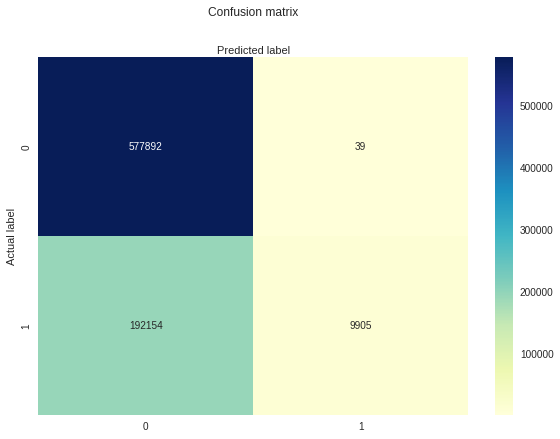

In [21]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [22]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Precision: 0.9960780370072405
Recall: 0.04902033564453947
Accuracy: 0.753595558917422


#### Discussion

**Explain your code and discuss results**

## Problem 4 [4 points]

Consider we want to cluster airports depending on their properties, such as average number of flights per day, delays, cancellations, etc.

Measure the quality of your clustering result.

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

airport_stats = spark.sql("""SELECT name, AVG(DEP_DELAY) as dep_delay, AVG(ARR_DELAY) as arr_delay FROM flights
                    JOIN airports ON airports.iata_code=flights.ORIGIN where cancelled=0 GROUP BY name""")


assembler = VectorAssembler(inputCols=("dep_delay", "arr_delay"), outputCol = "features")
dataset = assembler.transform(airport_stats)

cluster_qualities = []
bestK = 0
bestQ = 1

for i in range(5, 10): 
    kmeans = KMeans().setK(i).setSeed(1)
    model = kmeans.fit(dataset)
    centers = model.clusterCenters()
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    evaluator.setPredictionCol("prediction")
    currentQ = evaluator.evaluate(predictions)
    cluster_qualities.append(currentQ)
    if currentQ < bestQ:
        bestQ = currentQ
        bestK = i
    else:
        continue

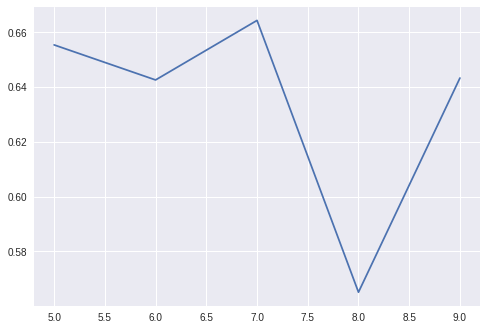

In [53]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(5, 10)], cluster_qualities)

In [26]:
kmeans = KMeans().setK(bestK).setSeed(1)
model = kmeans.fit(dataset)
centers = model.clusterCenters()
predictions = model.transform(dataset)

In [28]:
evaluator = ClusteringEvaluator()
evaluator.setPredictionCol("prediction")
print( "Quality of predictions (higher is better):" + str(evaluator.evaluate(predictions)))

Quality of predictions (higher is better):0.5650567242570361


In [29]:
predictionsPD = predictions.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


<AxesSubplot:xlabel='x', ylabel='y'>

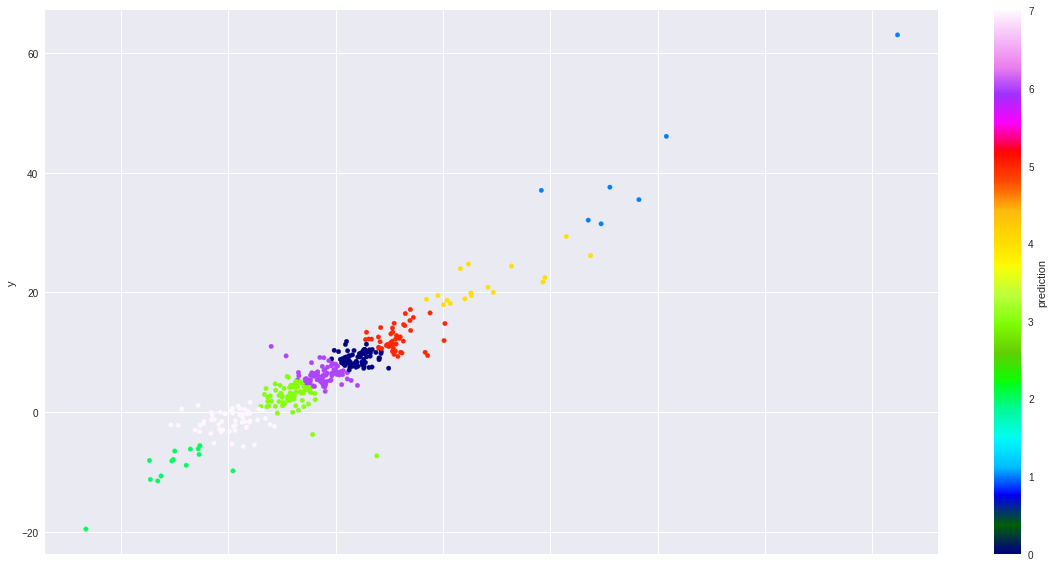

In [50]:
predictionsPD.plot.scatter(figsize=(20,10), x="x", y="y", c="prediction",s=20,cmap='gist_ncar') 

#### Discussion

**Explain your code and discuss results**

## Problem 5 [3 points]

We now want to find communities of airports, i.e., airports that are connected based on the flights that exist.

Propose an algorithm to solve this problem and plot the communities as a graph. Run the program with and without GPU support.

In [16]:
import matplotlib.pyplot as plt
from graphframes import *


e = spark.sql( """SELECT origin AS src,
         dest AS dst,
         COUNT(*) AS cnt
         FROM flights
         GROUP BY src, dst
         ORDER BY cnt DESC""")

e.createOrReplaceTempView("edges")
e.show()


v = spark.sql( """SELECT f.id, 
            FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',1))) AS lon, 
            FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',-1))) AS lat 
            FROM 
                (SELECT src AS id 
                FROM edges
                
                UNION 
                
                SELECT dst AS id 
                FROM edges) f 
            JOIN airports a 
            ON f.id = a.iata_code""")

g = GraphFrame(v, e)

+---+---+----+
|src|dst| cnt|
+---+---+----+
|SFO|LAX|5589|
|LAX|SFO|5557|
|JFK|LAX|4352|
|LAX|JFK|4351|
|OGG|HNL|4133|
|LAX|LAS|4106|
|HNL|OGG|4102|
|LAS|LAX|4097|
|LGA|ORD|3787|
|ORD|LGA|3761|
|LGA|ATL|3370|
|ATL|LGA|3367|
|ATL|MCO|3327|
|MCO|ATL|3325|
|LAX|ORD|3268|
|ORD|LAX|3166|
|ANC|SEA|3149|
|SEA|ANC|3148|
|KOA|HNL|3129|
|HNL|KOA|3085|
+---+---+----+
only showing top 20 rows



In [17]:
resultz = g.labelPropagation(maxIter=5)
resultz.select("id", "label").show()

+---+------------+
| id|       label|
+---+------------+
|BTM|661424963585|
|OGS|661424963585|
|ATW|661424963585|
|ALO|661424963585|
|HTS|858993459200|
|YAK|661424963585|
|DLG|592705486851|
|SNA|592705486851|
|BOS|592705486851|
|IMT|661424963585|
|MFR|661424963585|
|BWI|592705486851|
|ABI|661424963585|
|SCE|661424963585|
|BGM|858993459200|
|GTR|661424963585|
|UIN|661424963585|
|AKN|592705486851|
|FAT|661424963585|
|YUM|661424963585|
+---+------------+
only showing top 20 rows



<AxesSubplot:xlabel='lon', ylabel='lat'>

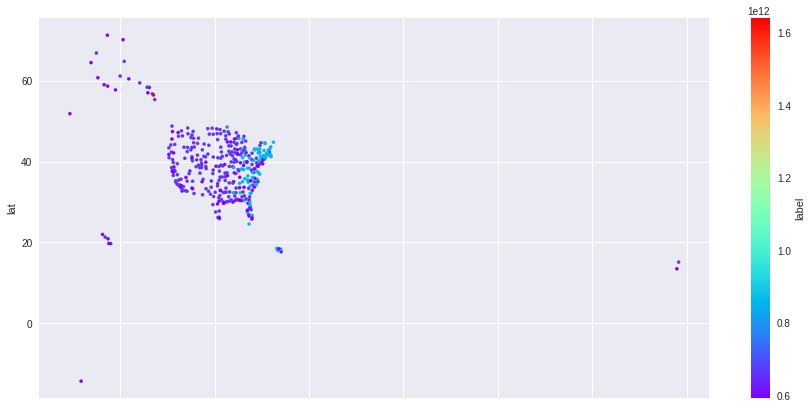

In [18]:
dff= resultz.toPandas()
dff.plot(x="lon",y="lat",c="label",s=10,cmap="rainbow",kind="scatter",figsize=(15,7))

In [22]:
edges = spark.sql( """SELECT
    origin AS src,
    dest AS dst,
    COUNT(*) AS cnt
    FROM flights
    GROUP BY src, dst""")
edges.createOrReplaceTempView("edges")

In [23]:
vertices = spark.sql( """SELECT f.id,
    FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',1))) AS lon,
    FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',-1))) AS lat
    FROM (SELECT src AS id FROM edges
    UNION SELECT dst AS id FROM edges) f
    JOIN airports a ON f.id = a.iata_code""")

In [24]:
from graphframes import *
g = GraphFrame(vertices, edges)
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
|{MEM, -89.9767, 3...|  {MEM, AMA, 44}|{AMA, -101.706, 3...|  {AMA, MEM, 44}|
|{GSP, -82.2189, 3...|{GSP, ATL, 1150}|{ATL, -84.4281, 3...|{ATL, GSP, 1151}|
|{MCO, -81.309, 28...| {MCO, BQN, 270}|{BQN, -67.1294, 1...| {BQN, MCO, 270}|
|{SJU, -66.0018, 1...|  {SJU, CLE, 17}|{CLE, -81.8498, 4...|  {CLE, SJU, 15}|
|{EWR, -74.1687, 4...|  {EWR, DSM, 94}|{DSM, -93.6631, 4...|  {DSM, EWR, 98}|
|{MCO, -81.309, 28...|  {MCO, DSM, 14}|{DSM, -93.6631, 4...|  {DSM, MCO, 14}|
|{STT, -64.9734, 1...|  {STT, EWR, 55}|{EWR, -74.1687, 4...|  {EWR, STT, 55}|
|{ATL, -84.4281, 3...|  {ATL, FSD, 86}|{FSD, -96.7419, 4...|  {FSD, ATL, 86}|
|{LIT, -92.2243, 3...| {LIT, LAS, 137}|{LAS, -115.152, 3...| {LAS, LIT, 137}|
|{OXR, -119.207, 3...|  {OXR, LAX, 51}|{LAX, -118.408, 3...|  {L

In [25]:
directed_out=g.outDegrees
edges = edges.join(directed_out,edges.src==directed_out.id,"left")
edges = edges.where("cnt>=(0.10*outDegree)")
g = GraphFrame(vertices, edges)

result = g.labelPropagation(maxIter=5)
result = result.where(col("lon")<=140)
result.select("id", "label").show()

+---+-------------+
| id|        label|
+---+-------------+
|BTM| 858993459200|
|OGS| 858993459200|
|ATW| 858993459200|
|ALO| 858993459200|
|HTS| 858993459200|
|YAK|1047972020225|
|DLG| 592705486851|
|SNA| 858993459200|
|BOS| 858993459200|
|IMT| 858993459200|
|MFR| 858993459200|
|BWI| 858993459200|
|ABI| 858993459200|
|SCE| 858993459200|
|BGM| 858993459200|
|GTR| 858993459200|
|UIN| 858993459200|
|AKN| 592705486851|
|FAT| 858993459200|
|YUM| 858993459200|
+---+-------------+
only showing top 20 rows



Plotting airport location - using communities for different color


<AxesSubplot:xlabel='lon', ylabel='lat'>

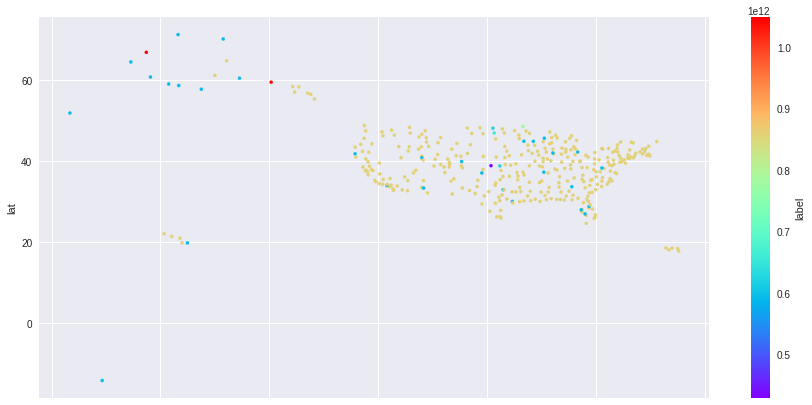

In [13]:
print('Plotting airport location - using communities for different color')
result = result.toPandas()
result.plot(x="lon",y="lat",c="label",s=10,cmap="rainbow",kind="scatter",figsize=(15,7))

In [15]:
result

,id,lon,lat,label
0,BTM,-112.497002,45.954800,858993459200
1,OGS,-75.465500,44.681900,858993459200
2,ATW,-88.519096,44.258099,858993459200
3,ALO,-92.400299,42.557098,858993459200
4,HTS,-82.557999,38.366699,858993459200
...,...,...,...,...
361,OGG,-156.429993,20.898600,858993459200
362,GSO,-79.937302,36.097801,858993459200
363,ACT,-97.230499,31.611300,858993459200
364,PSC,-119.119003,46.264702,858993459200


#### Discussion

**Explain your code and discuss results**